# Regularization

Here we will apply regularization to the inverse problem using linearized least squares. We will use a simple least squares minimizer from [here](https://www.researchgate.net/publication/274138835_NumPy_SciPy_Recipes_for_Data_Science_Regularized_Least_Squares_Optimization). 

In [1]:
#!/usr/bin/env python
import numpy.linalg as la
import scipy.sparse.linalg as sla
import math

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import copy

In [2]:

def rlsq_solution_V1(X, y, l):
    n, m = X.shape
    I = np.identity(m)
    w = np.dot(np.dot(la.inv(np.dot(X.T, X) + l*I), X.T), y)
    return w

def trivial_invert(X, y) :
    w = np.dot( np.dot( la.inv( np.dot(X.T,X) ), X.T), y )
    return w


### Detector response smearing function
def smear(x, mu, s ):
    return s * np.random.randn() + mu + x

### Parameters

In [3]:
# Mean and width for true distribution
true_val,true_width = 0.4, 0.1
# Bin width for matrix:
binwidth = 0.1
# Number of pseudoexperiments to generate response matrix
N_pe = 100000
# Mean and width for Gaussian smearing
mu = 0.02
sigma = 0.01
# Regulate?
regulate = True
# Simple input or Gaussian distribution?
simpleInput = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


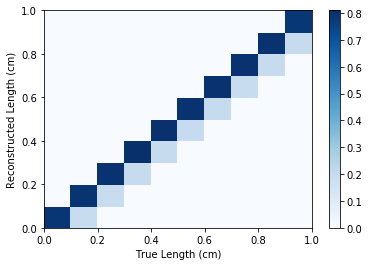

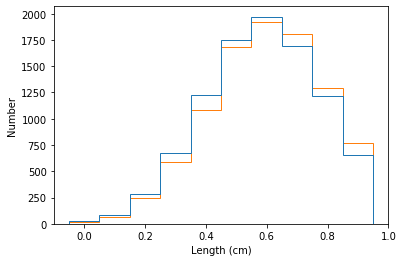

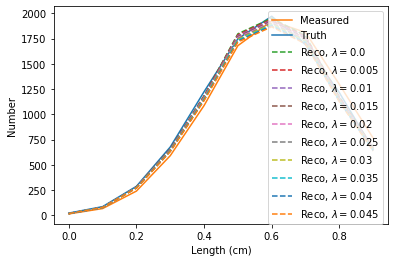

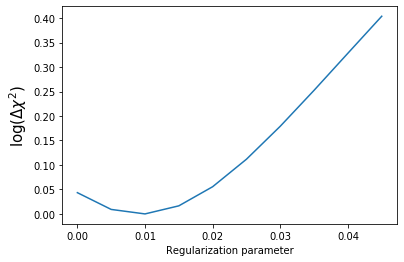

In [4]:
# True values for response matrix
xtrue = np.random.rand(N_pe)
# Smeared values for response matrix
xreco = copy.copy(xtrue)
for i,x in enumerate(xreco):
    xreco[i] = smear(x,mu=mu,s=sigma)
# Weights to create response matrix... matplotlib's histograms have unity *integrals*, not response
w = np.ones_like( xtrue )
w /= N_pe * binwidth
# Values for the x axis ranges
xvals = np.arange(0,1.0,binwidth)
xbins = np.linspace(0,1.0, num=1./binwidth + 1)


# Draw the response matrix    
plt.figure(1)
G, xbins2d, ybins2d, patches2d = plt.hist2d(xreco,xtrue, bins=[xbins,xbins], weights=w, cmap='Blues')
plt.xlabel('True Length (cm)')
plt.ylabel('Reconstructed Length (cm)')
plt.colorbar()

# Create a "truth" distribution
if simpleInput == False:
    truth = np.random.normal( loc=true_val, scale=true_width, size=10000 )
else : 
    truth = [0.2, 0.3, 0.4, 0.5]
# Smear the "truth" distribution
data = np.zeros_like(truth)
for i,datum in enumerate(truth) :
    data[i] = smear(datum,mu=mu,s=sigma)



# Draw the true and smeared distributions    
plt.figure(2)
returnvals,xbinsout,patches = plt.hist([truth,data],bins=xbins-binwidth*0.5, histtype='step')
t = returnvals[0]
d = returnvals[1]
plt.xlabel('Length (cm)')
plt.ylabel('Number')


# Draw the true, measured, and reconstructed distributions
plt.figure(3)
truthplot, = plt.plot(xvals, t)
meas, = plt.plot(xvals, d)
toplot = []
if regulate:
    regparams = np.arange(10) * 0.005
else :
    regparams = np.zeros(1)
regtitles = [ 'Reco, $\lambda=$' +str(iv) for iv in regparams]
chi2vals = []
for l in regparams:
    if regulate : 
        m = rlsq_solution_V1(G, d, l)
    else :
        m = trivial_invert(G,d)
    reco, = plt.plot(xvals, m, '--')
    toplot.append( reco )
    val = np.log( np.linalg.norm( t-m ) )
    chi2vals.append( val )

plt.legend( [meas,truthplot] + toplot, ['Measured', 'Truth'] + regtitles)
plt.xlabel('Length (cm)')
plt.ylabel('Number')

# Draw the chi2 as a function of regularization parameter
plt.figure(4)
minchi2 = min( chi2vals )
for ichi2,chi2 in enumerate(chi2vals):
    chi2vals[ichi2] -= minchi2
plt.plot( regparams, chi2vals)
plt.xlabel('Regularization parameter')
plt.ylabel(r'$\log(\Delta \chi^2)$', fontsize=15)
plt.show()